# Predicting Structured Data Utilizing Multi-Layer Perceptron (MLP) and Random Forests (RF)
This is a small demonstration of two Machine Learning Models to compare its predictive power in a structured dataset (numerical images from the sikit learn library). This Jupyter Notebook is available for [download at my git repository](, the code includes the import of the relevant dataset. The models will be resolving the same problem with the same dataset. Data Analysis of the results will be presented in the Looker Studio section. Be mindful of the considerations of the model specified at the end of the Notebook before extrapolating these results.

# Getting the data

We import load_digits from sklearn, the object that contains the digits dataset, as well as all other libraries that are required for this anlaysis

In [4]:
import os
os.getcwd()

'C:\\Users\\bmala'

In [5]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.linear_model import LinearRegression
from numpy.linalg import norm
import matplotlib.pyplot as plt

galton_df = pd.read_csv(r"C:\Users\bmala\Downloads\archive\GaltonFamilies.csv")
galton_df.head()


,rownames,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,001,78.5,67.0,75.43,4,1,male,73.2
1,2,001,78.5,67.0,75.43,4,2,female,69.2
2,3,001,78.5,67.0,75.43,4,3,female,69.0
3,4,001,78.5,67.0,75.43,4,4,female,69.0
4,5,002,75.5,66.5,73.66,4,1,male,73.5


We do not need columns rownames and family, as in our case use we will not know which family users belong, and, crucially, family could be a great indicator of non included variables (such as congenital health issues, income, etc).

In [7]:
galton_df = galton_df.drop(['rownames', 'family','childNum'], axis=1)

Lets transform heights into centimeters

In [9]:
galton_df['father'] = galton_df['father'] * 2.54
galton_df['mother'] = galton_df['mother'] * 2.54
galton_df['midparentHeight'] = galton_df['midparentHeight'] * 2.54
galton_df['childHeight'] = galton_df['childHeight'] * 2.54

One-Hot Encode column 'gender'

In [11]:
galton_df = pd.get_dummies(galton_df, columns=['gender'], drop_first=True)
galton_df['gender_male'] = galton_df['gender_male'].astype(int)

Now lets see the data distribution

In [13]:
galton_df.describe()

,father,mother,midparentHeight,children,childHeight,gender_male
count,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000
mean,175.760657,162.786805,175.785203,6.171306,169.534666,0.514989
std,6.290257,5.818851,4.578020,2.729025,9.091298,0.500043
min,157.480000,147.320000,163.576000,1.000000,142.240000,0.000000
25%,172.720000,160.020000,173.075600,4.000000,162.560000,0.000000
50%,175.260000,162.560000,175.889920,6.000000,168.910000,1.000000
75%,180.340000,167.322500,178.155600,8.000000,177.038000,1.000000
max,199.390000,179.070000,191.592200,15.000000,200.660000,1.000000


# Spliting the data for training and testing
The data will be split into two sub datasets, one for training, one for testing. Proportions will be 80% and 20% respectively. Do note that it is preferable to do feature engineering to save some time before doing the split (except for the validation set which should be kept separated at all times), but since im not doing feature engineering in this small example we will procede with this step right away. Predictions in the test sets will be compared later between the two models. As there is no engineering, there will also not be a validation set.

Dataset for RF

In [16]:
df_train, df_test = train_test_split(galton_df, test_size=0.2, random_state=42)

print('Rows in each Dataframe')
print('train: ', str(df_train.shape[0]))
print('test: ', str(df_test.shape[0]))

X_train = df_train.drop('childHeight', axis=1)
y_train = df_train['childHeight']

X_test = df_test.drop('childHeight', axis=1)
y_test = df_test['childHeight']

Rows in each Dataframe
train:  747
test:  187


Dataset for MLP

In [18]:
def dataframe_to_tensor(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32) 
    y_tensor = torch.tensor(y.values, dtype=torch.float32)   
    y_tensor = y_tensor.unsqueeze(1)
    tensor_dataset = TensorDataset(X_tensor, y_tensor)  
    return tensor_dataset
    
tensor_train = dataframe_to_tensor(X_train,y_train)
tensor_test = dataframe_to_tensor(X_test,y_test)

# Definiton and training of the CNN

This CNN will have two convolutional layers with max pooling applied to its outputs, and two fully conected layers

In [21]:
class MLP(torch.nn.Module):
    def __init__(self, input_features = X_train.shape[1], size_hidden = 250, n_output = 1):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_features, size_hidden, bias = False)
        self.hidden2 = nn.Linear(size_hidden, size_hidden, bias = False)
        self.out = nn.Linear(size_hidden, n_output, bias = False)
  # En la función forward se define cómo estarán conectadas las capas, es decir, como fluirán los datos
  # dentro de la red
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

Training the CNN Model

In [23]:
device = torch.device('cpu')
net = MLP()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters() , lr=learning_rate)
criterion = torch.nn.MSELoss()
num_epochs = 150
loader = DataLoader(dataset=tensor_train, batch_size=40, shuffle=True)

# Defining the forward and backward process
for i in range(num_epochs):
    for x, y in loader:
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        loss = criterion(net(x), y)
        loss.backward()
        optimizer.step()
        
torch.save(net.state_dict(), "./mlp2.pth")

Predicting in the test dataset with the CNN and obtaining the i

C:\Users\bmala\AppData\Local\Temp\ipykernel_18260\1891514108.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("./mlp2.pth"))


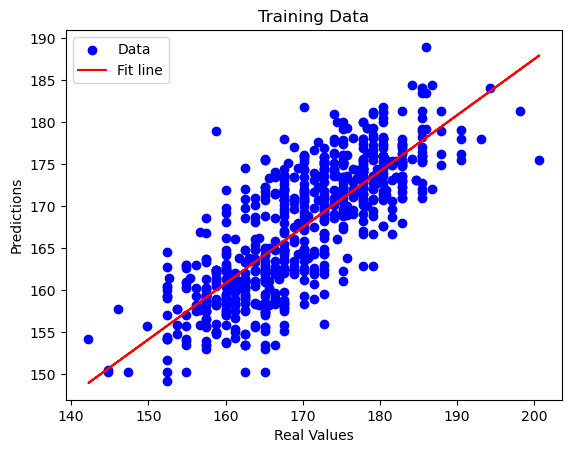

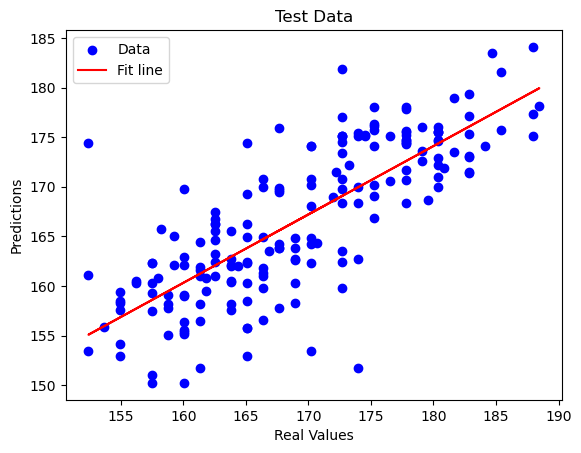

Mean Squared Error on Training Data: 36.76185607910156
Mean Squared Error on Test Data: 37.14622497558594


In [25]:
# Load model
net.load_state_dict(torch.load("./mlp2.pth"))
net.to(device)

# Create DataLoader for both training and test sets (correcting tensor usage)
loader_train = DataLoader(dataset=tensor_train, batch_size=100, shuffle=False)
loader_test = DataLoader(dataset=tensor_test, batch_size=100, shuffle=False)

# Method to plot scatter plot with regression line
def plotScatter(x_data, y_data, title, fit_line=True,datatype = "tensor"):
    plt.figure()
    plt.scatter(x_data, y_data, color='blue', label="Data")
    plt.xlabel('Real Values')
    plt.ylabel('Predictions')
    plt.title(title)

    if fit_line:
        if datatype == "tensor":
            X, Y = x_data.reshape(-1, 1), y_data.reshape(-1, 1)
        else:
            X,Y = x_data.values.reshape(-1, 1), y_data
        plt.plot(X, LinearRegression().fit(X, Y).predict(X), color='red', label="Fit line")
    
    plt.legend()
    plt.show()

# Extract training and test data from the dataloaders
def get_predictions(loader):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Ensure data is on the correct device
            preds = net(x_batch).cpu().numpy()  # Predict and move back to CPU
            all_preds.append(preds)
            all_labels.append(y_batch.cpu().numpy())  # Move labels back to CPU
    
    return np.concatenate(all_labels), np.concatenate(all_preds)

# Get predictions for training data
y_train_tensor, y_pred_train = get_predictions(loader_train)
plotScatter(y_train_tensor, y_pred_train, "Training Data")

# Get predictions for test data
y_test_tensor, y_pred_test = get_predictions(loader_test)
plotScatter(y_test_tensor, y_pred_test, "Test Data")

# Calculate and print the Mean Squared Error for both train and test data
train_mse = ((y_train_tensor - y_pred_train) ** 2).mean()
test_mse = ((y_test_tensor - y_pred_test) ** 2).mean()

print(f"Mean Squared Error on Training Data: {train_mse}")
print(f"Mean Squared Error on Test Data: {test_mse}")


# Definiton and training of the RF

In [27]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
train_mse = ((y_test_tensor - y_pred_test) ** 2).mean()
joblib.dump(rf, 'height_random_forest_model.joblib_1')

['height_random_forest_model.joblib_1']

Predicting in the test dataset with the RF and obtaining its outputs

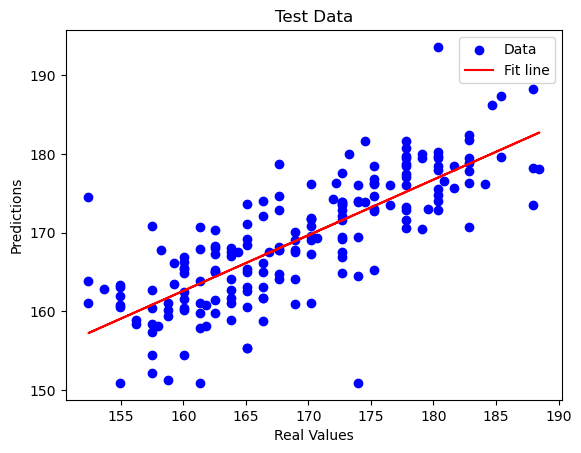

Mean Squared Error on Test Data: 31.1374695913187


In [29]:
y_pred_test_rf = rf.predict(X_test)
plotScatter(y_test, y_pred_test_rf, "Test Data",datatype="dataframe")
test_mse_rf = ((y_test - y_pred_test_rf) ** 2).mean()
print(f"Mean Squared Error on Test Data: {test_mse_rf}")

# Conclusions, Reflections and Warnings

You might notice that the code for the CNN is significantly more complex than the one for Random Forests. This was a deliberate decision to showcase my ability to understand the inner structure of a CNN. In truth, there are services available to make the CNN just as simple to code as the Random Forest. Both of these models are complex to code if done from scratch, but such is the beauty of public libraries.

In this example of unstructured data, the CNN performed much better than Random Forest (1 error every 100 samples in CNN vs 1 in 30 for RF on average). However, it must be taken into consideration that:

- This is a very small dataset
- There has been no feature engineering (which is recommended for the RF)
- "Classical" Machine Learning models such as RF perform much better in structured dataset
- There was no hyperparameter optimization, nor tweaking of the model structure
- Though it greatly depends on which dataset we are working on, for these examples, both the CNN and RF performed quite well as out-of-the-box or plug-and-play models.

Should the need arise to put something into production in a hurry, this would be an acceptable solution.
